In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
DATE_COL = 'date'
GROUP_COL = 'state'
DISTRICT_COL = 'district'
VALUE_COL_1 = 'demo_age_5_17'
VALUE_COL_2 = 'demo_age_17_'
df = pd.read_csv("demographic_processed.csv")
df[DATE_COL] = pd.to_datetime(
    df[DATE_COL],
    format='mixed',
    dayfirst=True,
    errors='coerce'
)

df = df.dropna(subset=[DATE_COL])
df['month_period'] = df[DATE_COL].dt.to_period('M')
df['month'] = df['month_period'].astype(str)

df['total_demo'] = df[VALUE_COL_1] + df[VALUE_COL_2]

# Prevent divide-by-zero
df['age_ratio'] = df[VALUE_COL_2] / df[VALUE_COL_1].replace(0, 1)

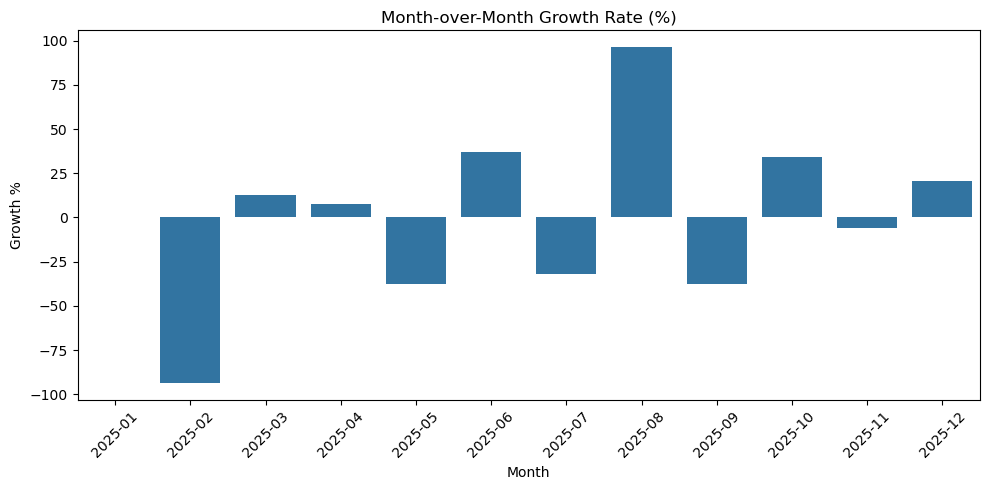

In [5]:
# MONTH-OVER-MONTH GROWTH
monthly = df.groupby('month')['total_demo'].sum().reset_index()
monthly['growth_%'] = monthly['total_demo'].pct_change() * 100
plt.figure(figsize=(10,5))
sns.barplot(x=monthly['month'], y=monthly['growth_%'])
plt.xticks(rotation=45)
plt.title("Month-over-Month Growth Rate (%)")
plt.xlabel("Month")
plt.ylabel("Growth %")
plt.tight_layout()
plt.show()

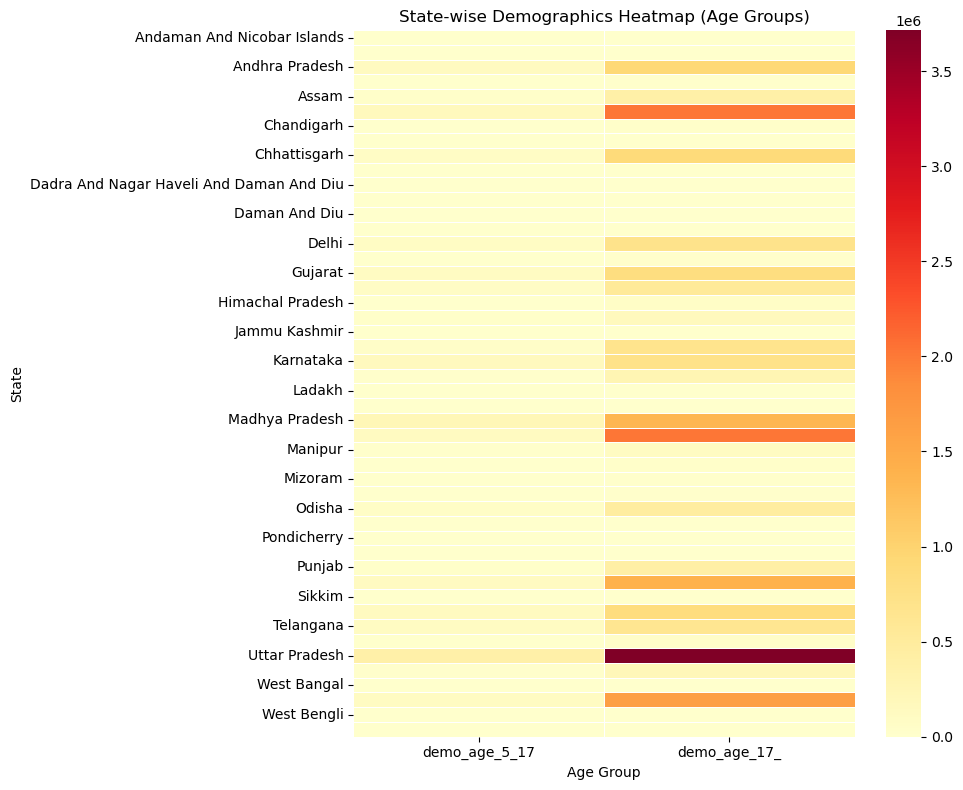

In [6]:
#STATE HEATMAP — AGE GROUP TOTALS
state_heatmap = df.groupby(GROUP_COL)[[VALUE_COL_1, VALUE_COL_2]].sum()
plt.figure(figsize=(10,8))
sns.heatmap(state_heatmap, cmap="YlOrRd", linewidths=0.5)
plt.title("State-wise Demographics Heatmap (Age Groups)")
plt.xlabel("Age Group")
plt.ylabel("State")
plt.tight_layout()
plt.show()

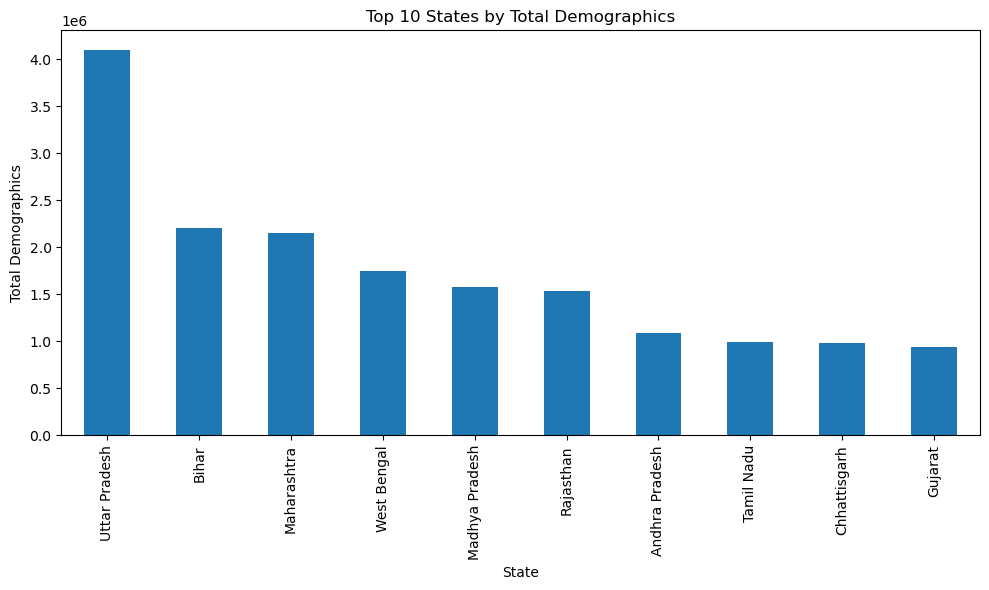

In [7]:

# TOP 10 STATES — TOTAL DEMOGRAPHICS
top_states = df.groupby(GROUP_COL)['total_demo'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
top_states.plot(kind='bar')
plt.title("Top 10 States by Total Demographics")
plt.xlabel("State")
plt.ylabel("Total Demographics")
plt.tight_layout()
plt.show()


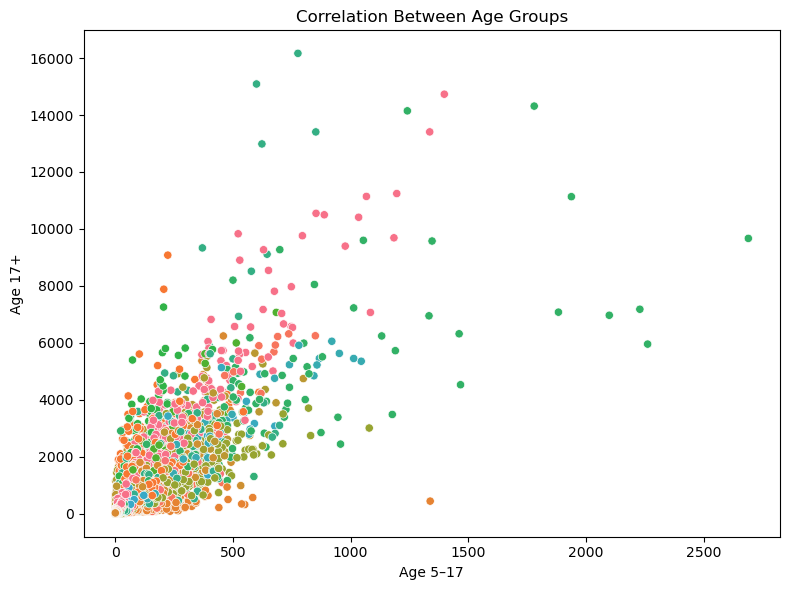

In [8]:
# CORRELATION SCATTER — AGE GROUPS
plt.figure(figsize=(8,6))
sns.scatterplot(
    x=VALUE_COL_1,
    y=VALUE_COL_2,
    hue=GROUP_COL,
    data=df,
    legend=False
)
plt.title("Correlation Between Age Groups")
plt.xlabel("Age 5–17")
plt.ylabel("Age 17+")
plt.tight_layout()
plt.show()


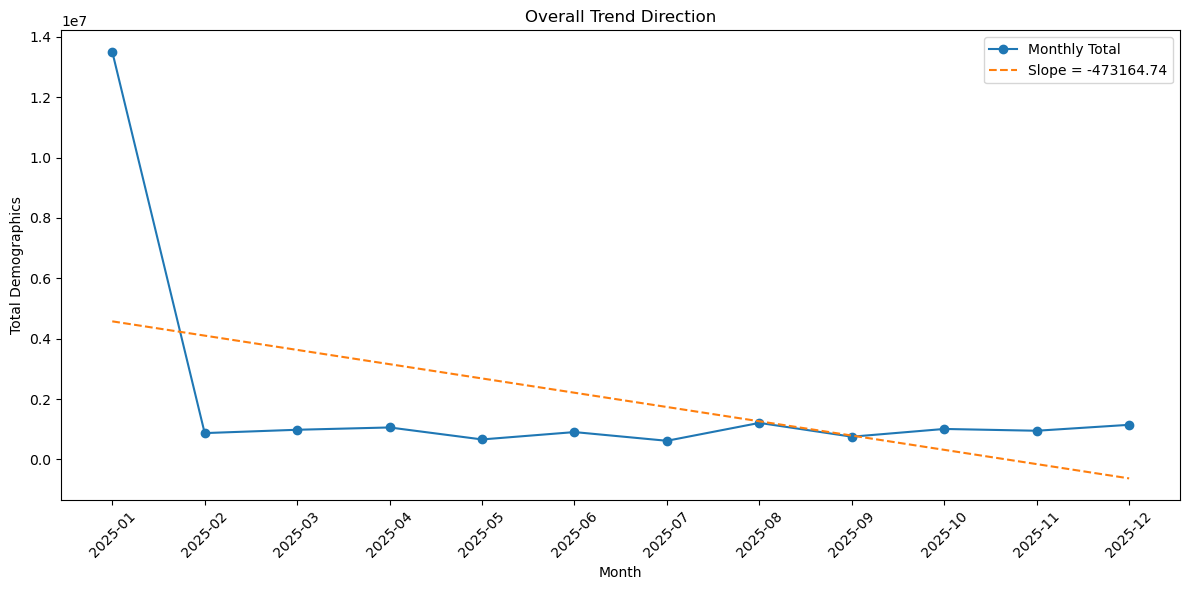

In [9]:
# OVERALL TREND DIRECTION (REGRESSION)
x = np.arange(len(monthly))
y = monthly['total_demo'].values

slope, intercept = np.polyfit(x, y, 1)
trend_line = slope * x + intercept

plt.figure(figsize=(12,6))
plt.plot(monthly['month'], y, marker='o', label="Monthly Total")
plt.plot(monthly['month'], trend_line, linestyle='--', label=f"Slope = {slope:.2f}")
plt.xticks(rotation=45)
plt.title("Overall Trend Direction")
plt.xlabel("Month")
plt.ylabel("Total Demographics")
plt.legend()
plt.tight_layout()
plt.show()

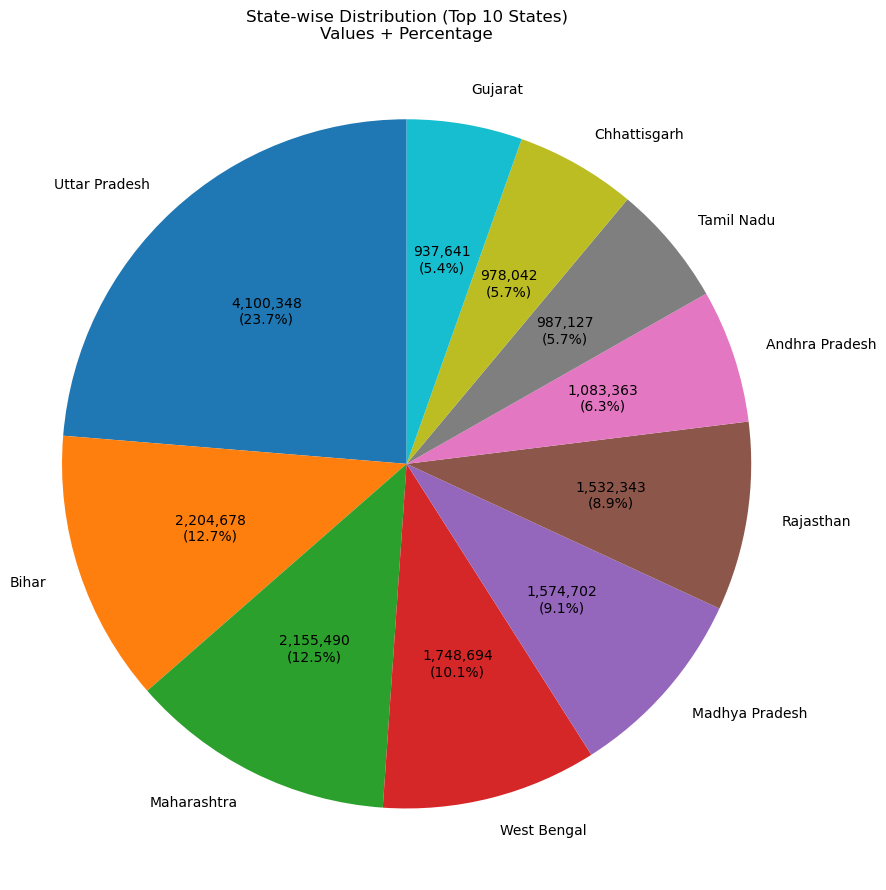

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv("demographic_processed.csv")
df['date'] = pd.to_datetime(df['date'], format='mixed', dayfirst=True, errors='coerce')
df = df.dropna(subset=['date'])
df['total_demo'] = df['demo_age_5_17'] + df['demo_age_17_']
state_totals = df.groupby('state')['total_demo'].sum()
top_states = state_totals.sort_values(ascending=False).head(10)
def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct * total / 100.0))
        return f"{val:,}\n({pct:.1f}%)"
    return my_format
plt.figure(figsize=(9,9))
plt.pie(top_states.values,
    labels=top_states.index,
    autopct=autopct_format(top_states.values),
    startangle=90)
plt.title("State-wise Distribution (Top 10 States)\nValues + Percentage")
plt.axis('equal')
plt.tight_layout()
plt.show()

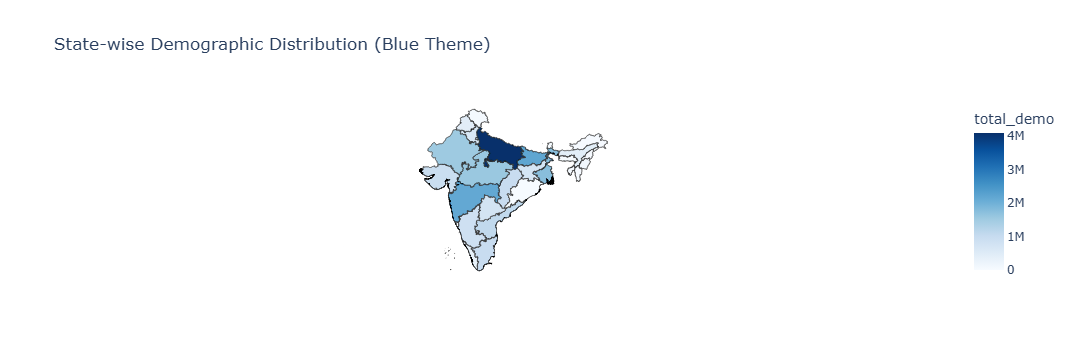

In [11]:
import pandas as pd
import plotly.express as px
df = pd.read_csv("demographic_processed.csv")
df['date'] = pd.to_datetime(df['date'], format='mixed', dayfirst=True, errors='coerce')
df = df.dropna(subset=['date'])
df['total_demo'] = df['demo_age_5_17'] + df['demo_age_17_']
map_data = df.groupby('state')['total_demo'].sum().reset_index()
geojson_url = "https://raw.githubusercontent.com/geohacker/india/master/state/india_telengana.geojson"
fig = px.choropleth(
    map_data,
    geojson=geojson_url,
    featureidkey="properties.NAME_1",
    locations="state",
    color="total_demo",
    color_continuous_scale="Blues",
    hover_name="state",
    hover_data={"total_demo": ":,"},
    title="State-wise Demographic Distribution (Blue Theme)"
)
fig.update_geos(fitbounds="locations", visible=False)
fig.add_scattergeo(
    locations=map_data["state"],
    locationmode="geojson-id",
    text=map_data["total_demo"].apply(lambda x: f"{x:,}"),
    mode="text",
    textfont=dict(size=10, color="black"),
    showlegend=False
)
fig.show()